In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [147]:
#df = pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022-test-10222023.csv', delimiter=',', skiprows=0, low_memory=False)
df = pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022-12212023.csv', delimiter=',', skiprows=0, low_memory=False)

In [148]:
df = df.drop(columns=['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'])

In [149]:
#validation= pd.read_excel(r'../../data/tidy/Jun2022-Sep2022-BEB-validation.xlsx')
# Renaming the 'Qty' column to 'trip'
#validation.rename(columns={'Qty': 'trip'}, inplace=True)
validation= pd.read_excel(r'../../data/tidy/BEB-validation.xlsx')

In [150]:
df_beb=df[df['Powertrain'] == 'electric'].copy()
df_beb.columns

Index(['ServiceDateTime', 'DateKey', 'CalendarDate', 'Year', 'Month', 'OpKey',
       'Operator', 'RtKey', 'RtKey2', 'Route', 'RouteName', 'TripKey', 'Trip',
       'StopKey', 'Stop', 'StopName', 'Vehicle', 'VehicleType', 'SeatedCap',
       'TotalCap', 'Lat', 'Lon', 'Boards', 'Alights', 'Onboard', 'Bike',
       'Daytype', 'Hour', 'Minute', 'Second', 'Date', 'Powertrain',
       'VehicleModel', 'Vehicle_mass', 'time_delta_in_seconds', 'dist',
       'Speed', 'Acceleration', 'elevation', 'grade', 'power', 'Energy',
       'P_t'],
      dtype='object')

In [151]:
# Convert the columns to sets
equipment_ids = set(validation['Equipment ID'])
vehicles = set(df_beb['Vehicle'])

# Find the difference
unique_equipment_ids = equipment_ids - vehicles
print('Unique vehicle ids that are in the validation data but not in the movement data',unique_equipment_ids)

Unique vehicle ids that are in the validation data but not in the movement data set()


In [152]:
# Convert date columns to datetime if they are not already
df_beb['Date'] = pd.to_datetime(df_beb['Date'])
validation['Transaction Date'] = pd.to_datetime(validation['Transaction Date'])

# Group by Date and Vehicle in df_beb and sum the Energy
grouped_energy = df_beb.groupby(['Date', 'Vehicle'])[['Energy', 'dist']].sum().reset_index()

# Merge the dataframes
merged_df = pd.merge(validation, grouped_energy, 
                     left_on=['Transaction Date', 'Equipment ID'], 
                     right_on=['Date', 'Vehicle'], 
                     how='left')

In [153]:
# Drop rows where 'trip' or 'Predicted Energy' is NaN
merged_df = merged_df.dropna(subset=['trip', 'Energy'])

# Drop rows where 'trip' or 'Predicted Energy' is 0
merged_df = merged_df.query("trip != 0 and `Energy` != 0")
merged_df

,Equipment ID,trip,charge,Transaction Date,Date,Vehicle,Energy,dist
0,3501,26.7,35.0,2022-06-01,2022-06-01,3501.0,26.439070,15.759902
1,3501,167.1,182.7,2022-06-02,2022-06-02,3501.0,177.817592,96.860943
3,3501,173.9,166.1,2022-06-06,2022-06-06,3501.0,173.512701,97.573532
4,3501,74.3,180.0,2022-06-07,2022-06-07,3501.0,96.522885,44.192232
5,3501,81.4,108.5,2022-06-08,2022-06-08,3501.0,75.847302,43.615372
...,...,...,...,...,...,...,...,...
269,1321,141.5,0.8,2022-09-26,2022-09-26,1321.0,135.443881,88.931381
270,1321,139.1,390.0,2022-09-27,2022-09-27,1321.0,120.232650,63.968701
271,1321,194.8,3.1,2022-09-28,2022-09-28,1321.0,149.394953,102.720630
272,1321,116.0,387.8,2022-09-29,2022-09-29,1321.0,64.610393,42.246626


In [154]:
merged_df['residual']=merged_df['trip']-merged_df['Energy']

In [155]:
from sklearn.model_selection import train_test_split

train_merged_df, test_merged_df = train_test_split(merged_df, test_size=0.2, random_state=42)

In [156]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_merged_df['trip'], test_merged_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_merged_df['trip'], test_merged_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.29
RMSE: 40.51


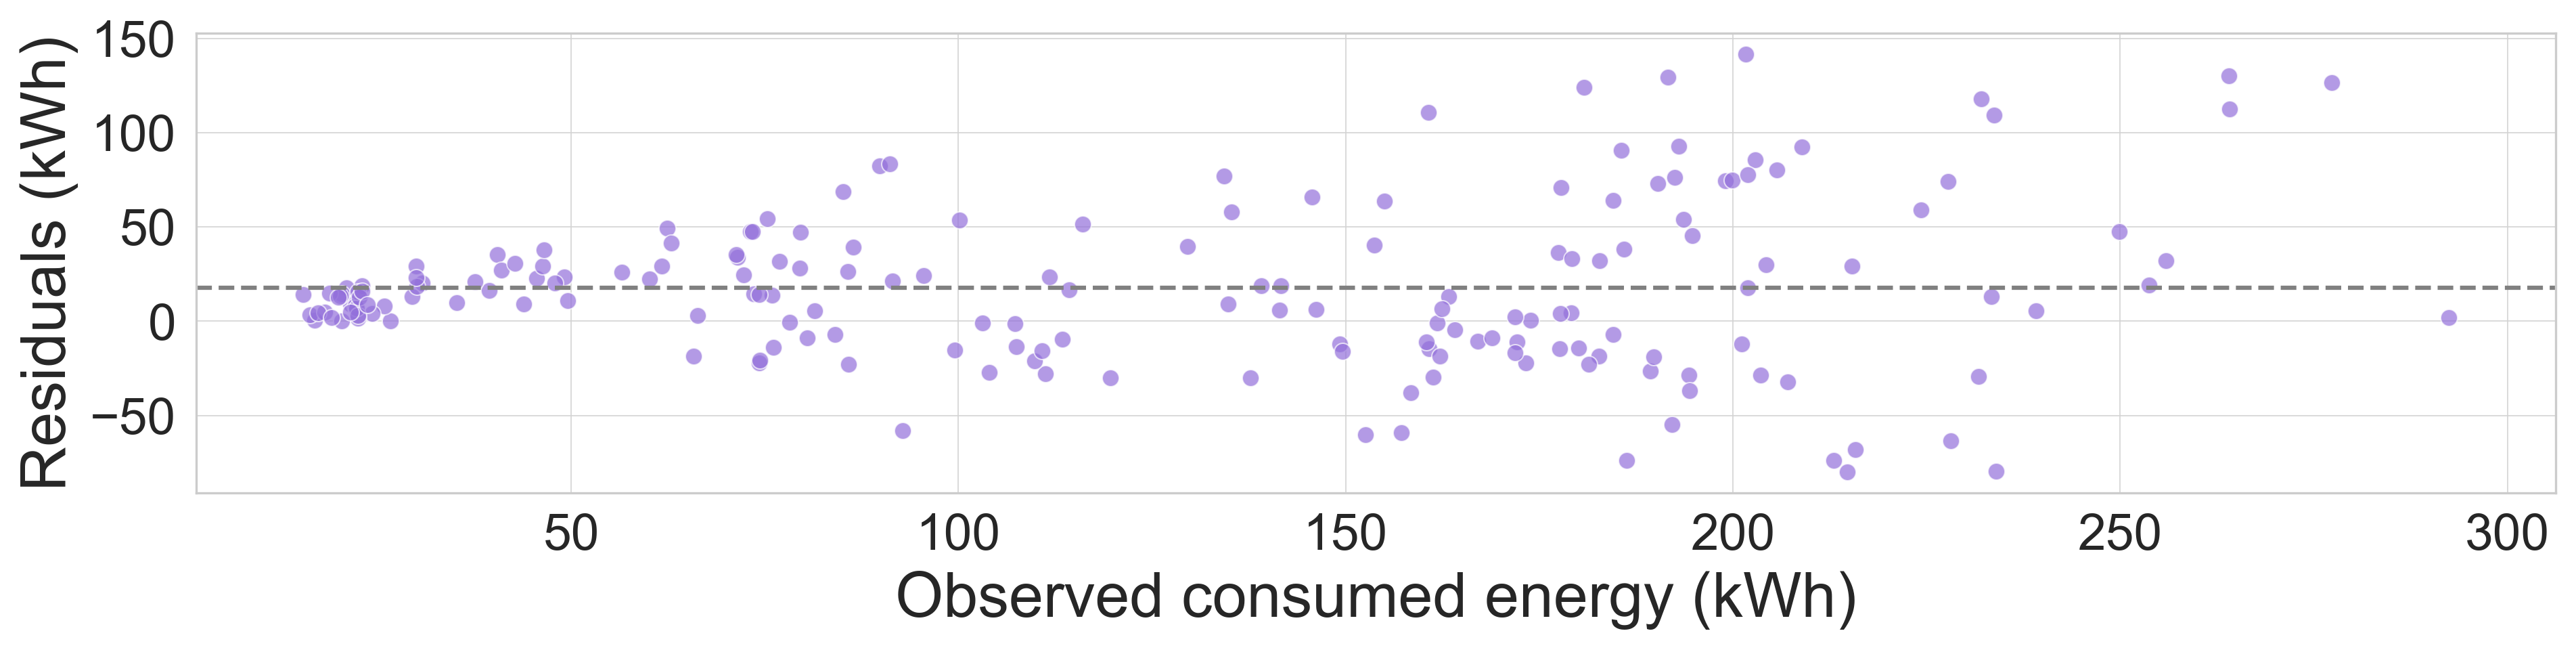

In [157]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='gallons', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='trip', y='residual', data=merged_df, color='mediumpurple', alpha=0.7)
plt.axhline(merged_df['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Observed consumed energy (kWh)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Set plot area color
ax.set_facecolor('white')
ax.grid(color='lightgrey', linewidth=0.4)
#ax.set_ylim(top=300)
#fig.savefig(r'../../figures/residuals-vs-consumed-energy-conventional.png', dpi=400, bbox_inches='tight')

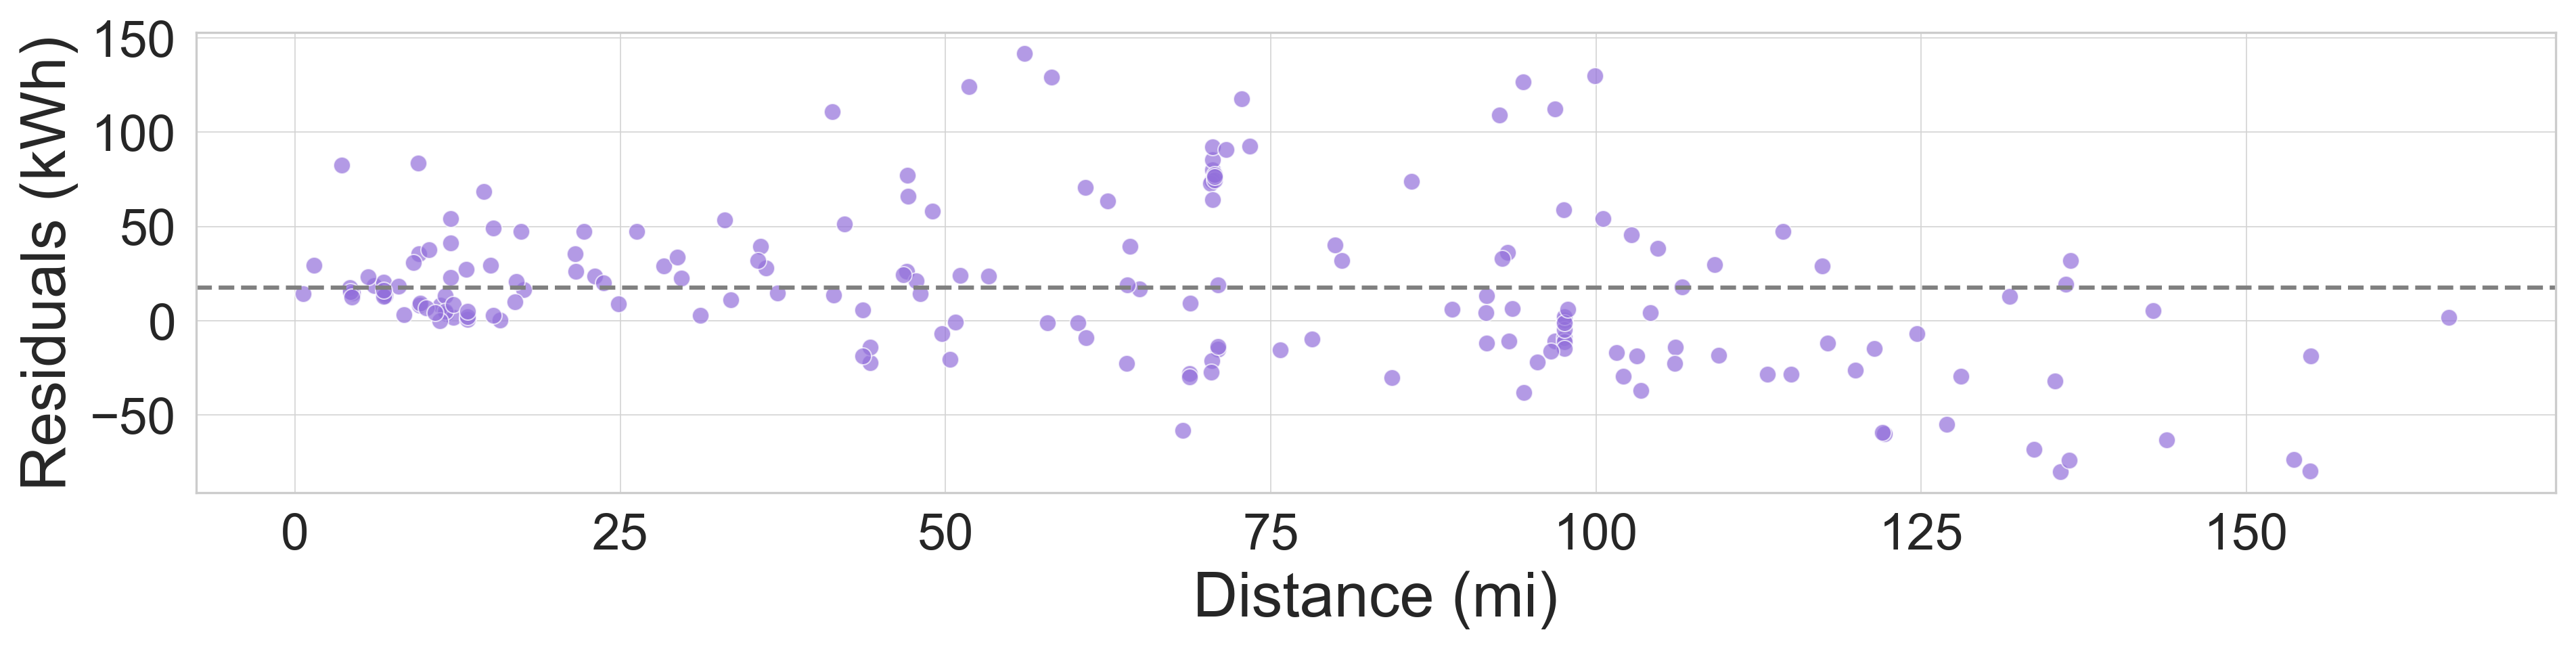

In [158]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='dist', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='dist', y='residual', data=merged_df, color='mediumpurple', alpha=0.7)
plt.axhline(merged_df['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Distance (mi)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.grid(color='lightgrey', linewidth=0.4)
#plt.plot(df_conventional['residual'].mean(), linewidth=2)
#fig.savefig(r'../../figures/residuals-vs-dist-conventional.png', dpi=400, bbox_inches='tight')

In [159]:
merged_df['economy']=merged_df['dist']/merged_df['Energy']

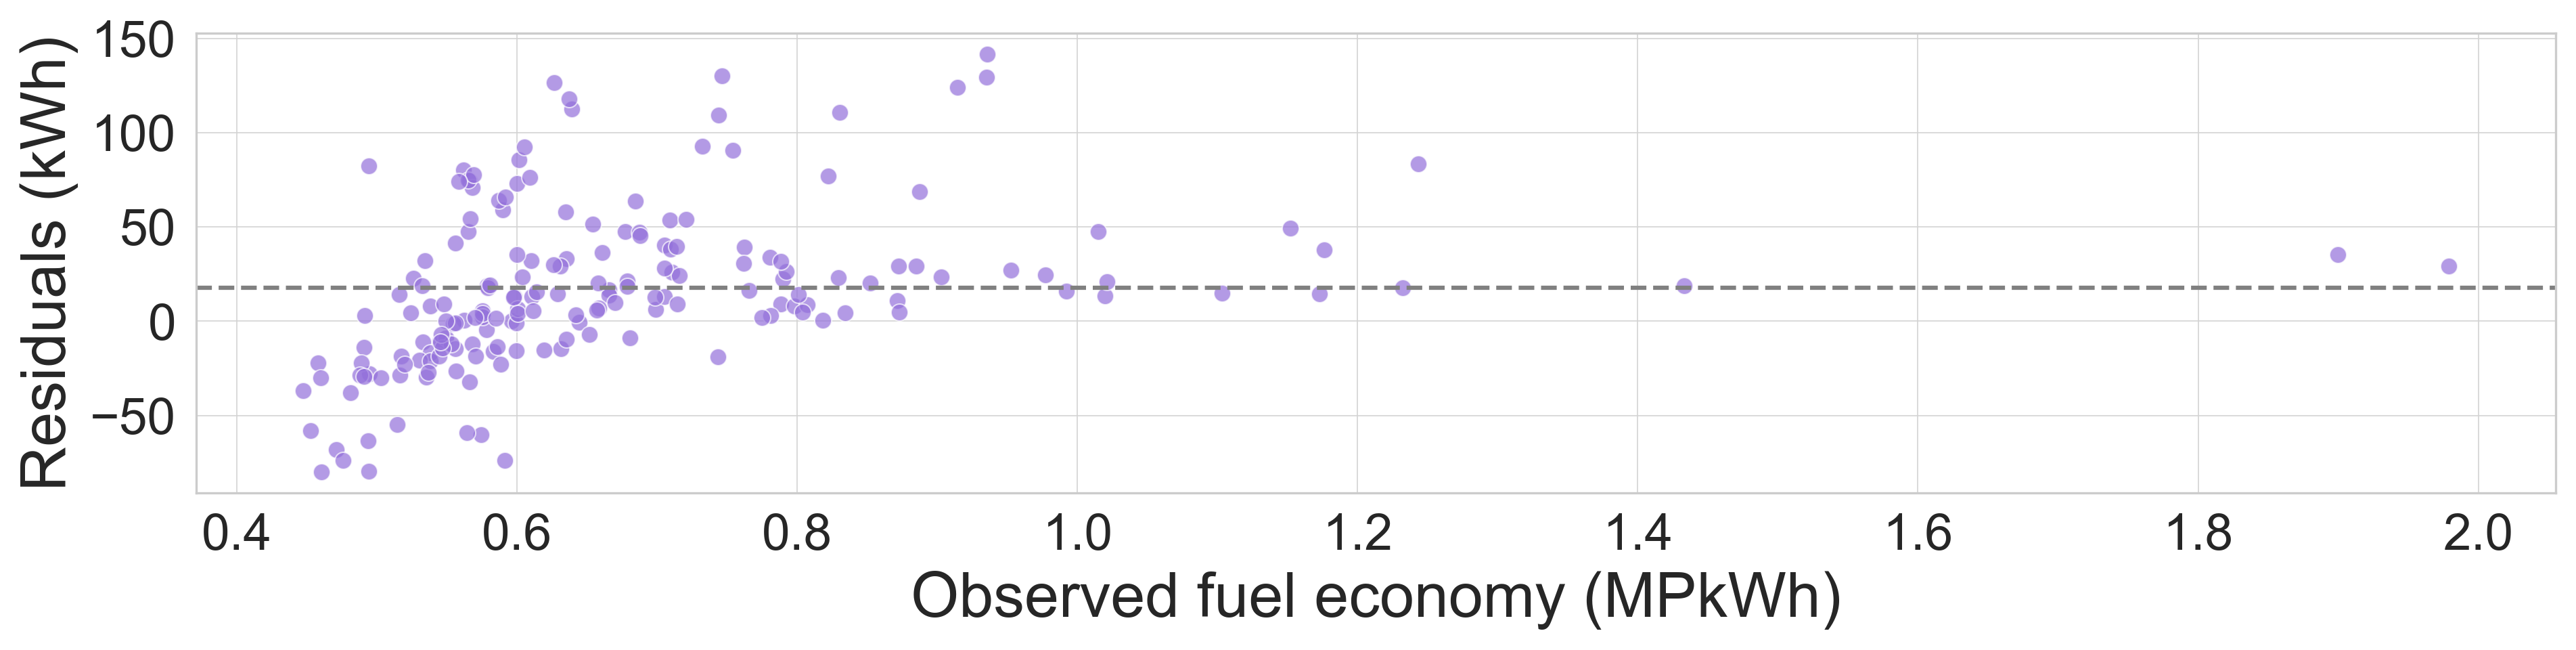

In [160]:
fig, ax = plt.subplots(figsize=(15,3), dpi=300)

sns.set_style("whitegrid")

#sns.scatterplot(x='gallons', y='residual', data=df_conventional, hue='VehicleModel', alpha=0.7)
sns.scatterplot(x='economy', y='residual', data=merged_df, color='mediumpurple', alpha=0.7)
plt.axhline(merged_df['residual'].mean(),color='gray', linestyle='--')
plt.ylabel('Residuals (kWh)', fontsize=22)
plt.xlabel('Observed fuel economy (MPkWh)', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# Set plot area color
ax.set_facecolor('white')
ax.grid(color='lightgrey', linewidth=0.4)
#fig.savefig(r'../../figures/residuals-vs-consumed-energy-conventional.png', dpi=400, bbox_inches='tight')

In [161]:
from sklearn.metrics import mean_squared_error
import numpy as np

observed = merged_df['Energy']
predicted = merged_df['trip']

rmse = np.sqrt(mean_squared_error(observed, predicted))
print('RMSE:', rmse)

RMSE: 45.673765851290284


In [162]:
merged_df['trip'].mean()

123.52637837837834

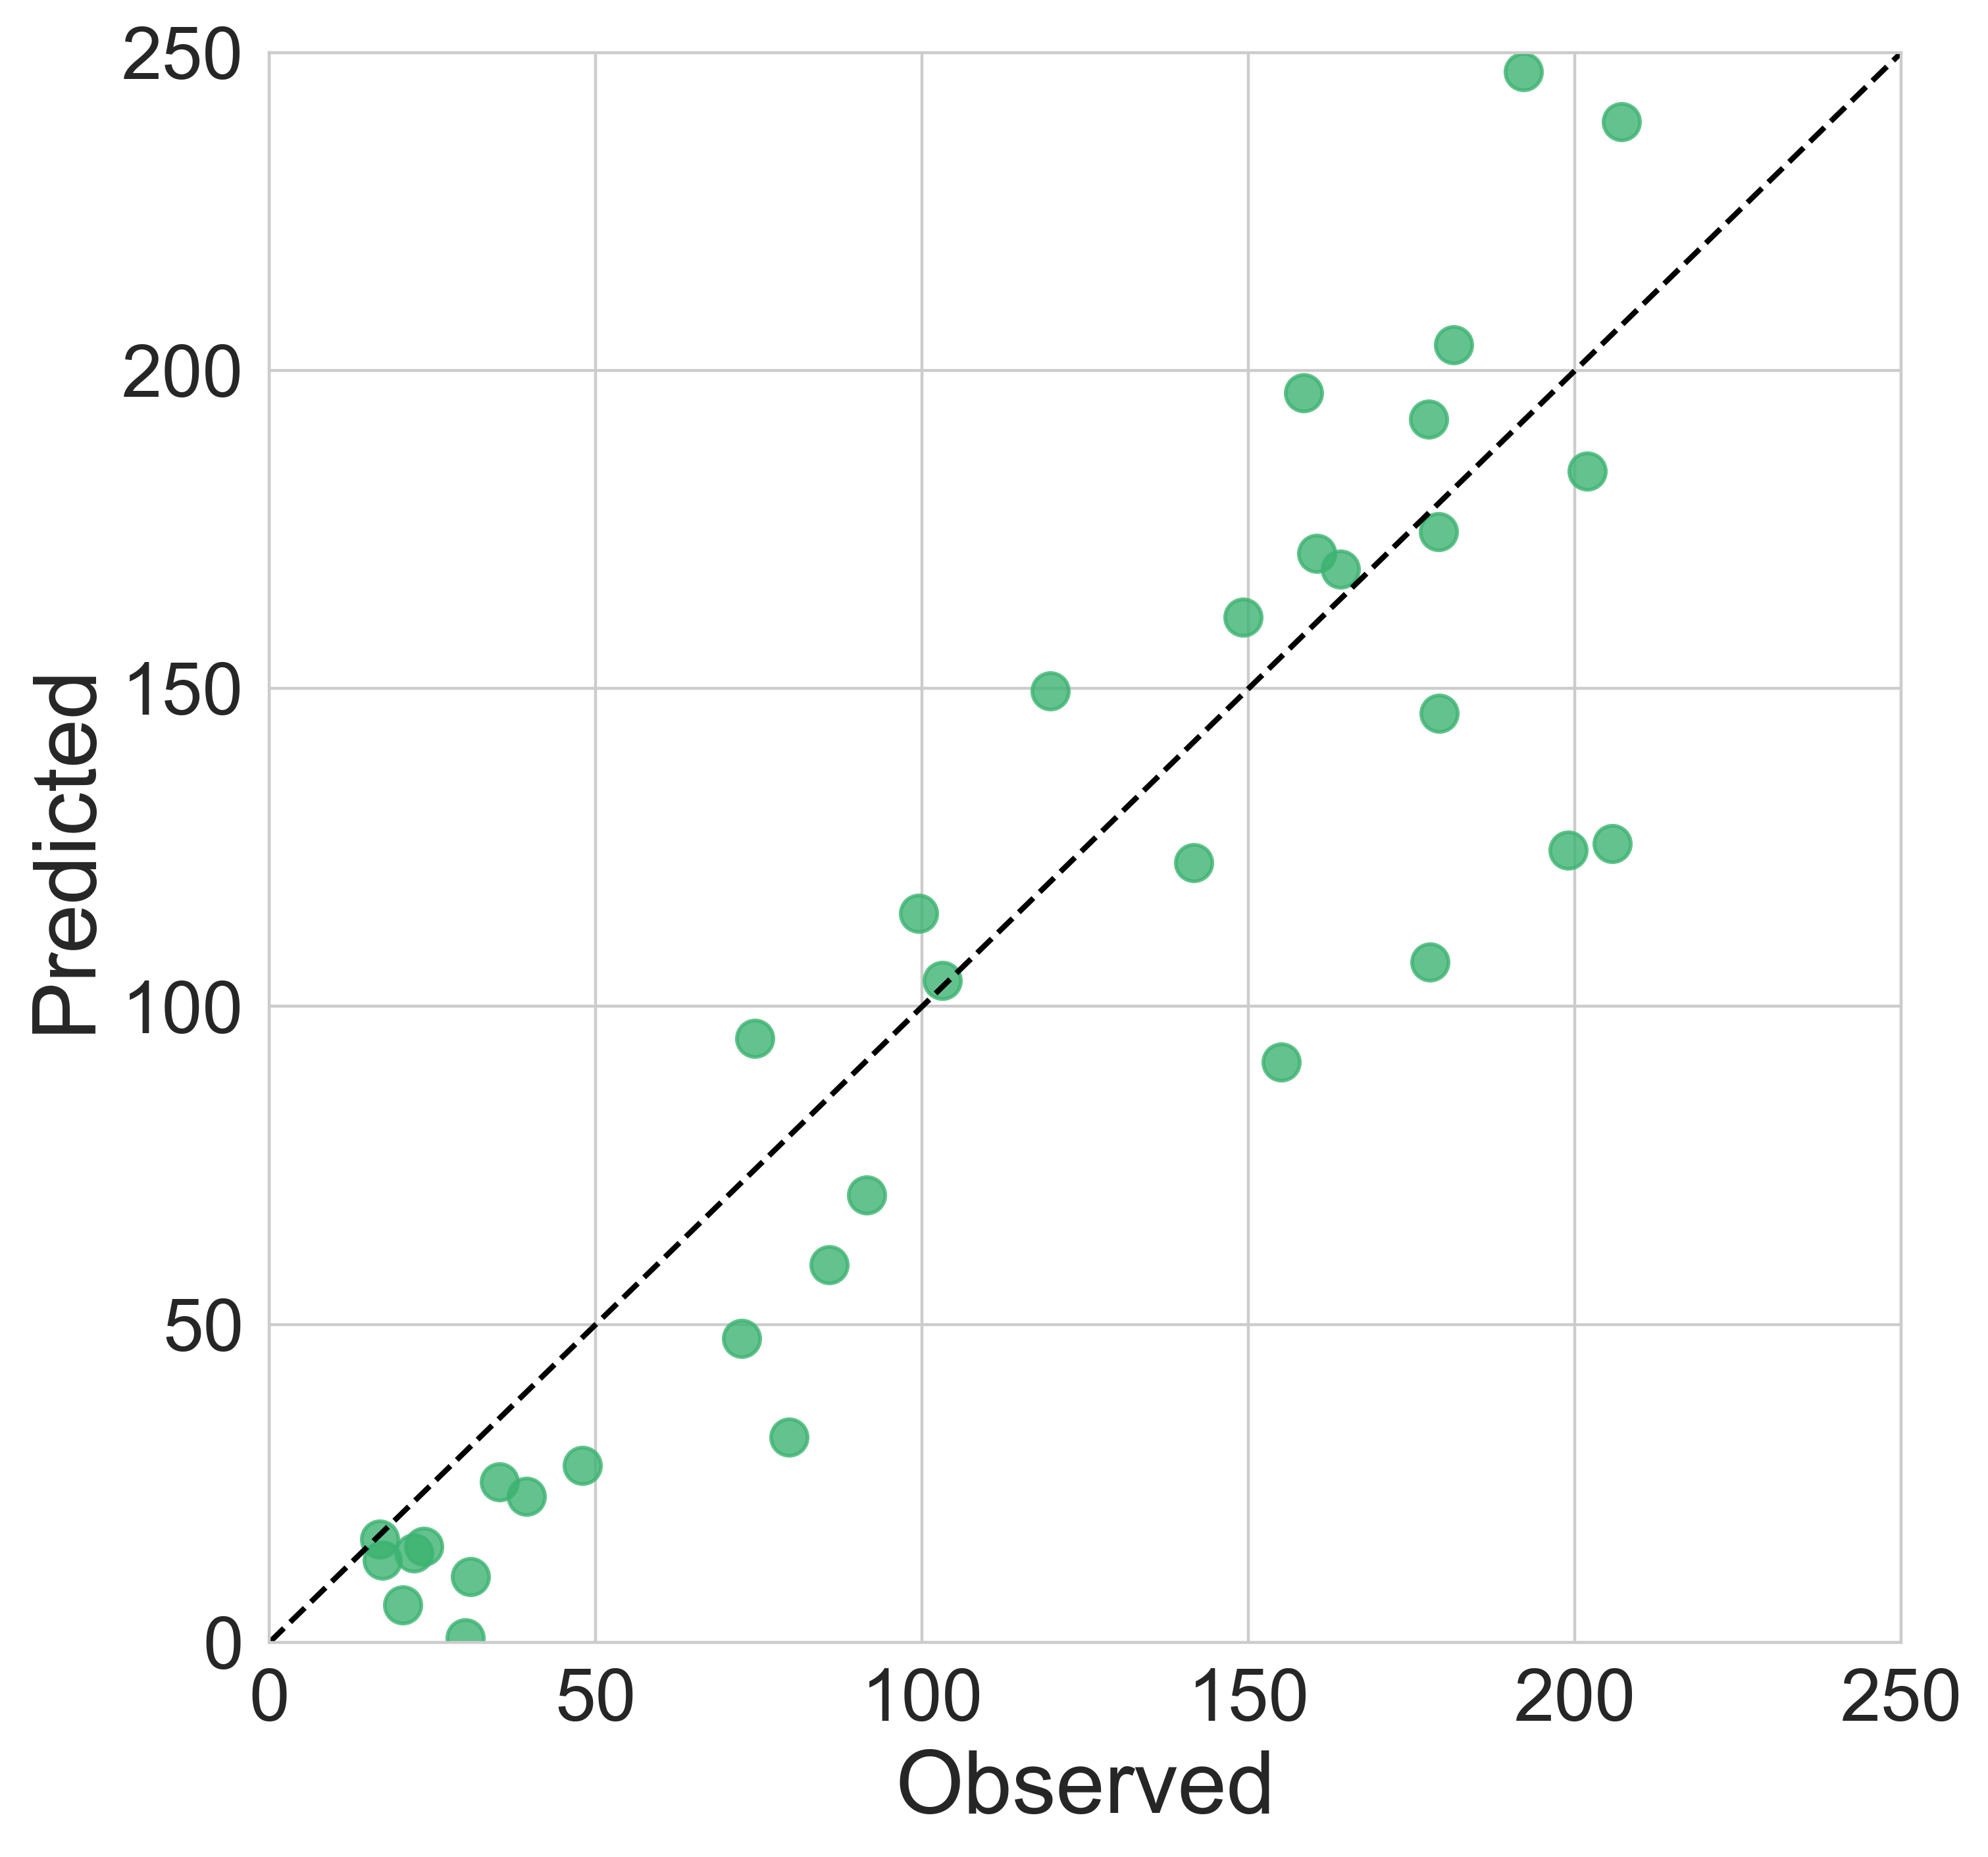

In [163]:
# create a new figure with specified size and DPI
fig = plt.figure(figsize=(8, 8), dpi=400)

# create a scatter plot of predicted vs observed
plt.scatter(test_merged_df['trip'], test_merged_df['Energy'], alpha=0.8, s=100, color='mediumseagreen')

# Calculate the minimum and maximum limits for x and y axes
xlim = ylim = (0, 250)
xy_min = min(xlim[0], ylim[0])
xy_max = max(xlim[1], ylim[1])

# add a reference line showing perfect agreement between predicted and observed values
plt.plot([xy_min, xy_max], [xy_min, xy_max], color='black', linestyle='dashed',zorder=2)

# set the axis limits
plt.xlim(xlim)
plt.ylim(ylim)

# set the axis labels
plt.ylabel('Predicted', fontsize=24)
plt.xlabel('Observed', fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True, zorder=1)


# show the plot
plt.show()

# Saving
fig.savefig(r'../../figures/BEB-observed-vs-predicted-sep2021-oct2022.png', dpi=400, bbox_inches='tight')

In [164]:
# Compute the absolute value of the residuals
merged_df['abs_residual'] = merged_df['residual'].abs()

# Get the top 30 rows with the largest absolute residuals
top_30 = merged_df.nlargest(30, 'abs_residual')

top_30

,Equipment ID,trip,charge,Transaction Date,Date,Vehicle,Energy,dist,residual,economy,abs_residual
71,1421,201.7,0.7,2022-08-05,2022-08-05,1421.0,59.892772,56.042432,141.807228,0.935713,141.807228
166,1421,264.0,267.3,2022-06-17,2022-06-17,1421.0,133.944421,99.933341,130.055579,0.746081,130.055579
136,1322,191.6,319.3,2022-07-07,2022-07-07,1322.0,62.223465,58.168329,129.376535,0.934829,129.376535
172,1421,277.3,14.1,2022-06-23,2022-06-23,1421.0,150.663758,94.382545,126.636242,0.626445,126.636242
83,1420,180.8,1.3,2022-08-25,2022-08-25,1420.0,56.639819,51.784133,124.160181,0.914271,124.160181
161,1421,232.1,0.0,2022-06-10,2022-06-10,1421.0,114.197783,72.740585,117.902217,0.636970,117.902217
118,1421,264.1,0.9,2022-07-12,2022-07-12,1421.0,151.603168,96.832910,112.496832,0.638726,112.496832
62,1323,160.7,78.3,2022-04-19,2022-04-19,1323.0,49.778764,41.319387,110.921236,0.830061,110.921236
249,1321,233.7,0.7,2022-09-02,2022-09-02,1321.0,124.475089,92.572169,109.224911,0.743700,109.224911
78,1420,193.0,73.3,2022-08-19,2022-08-19,1420.0,100.280190,73.407733,92.719810,0.732026,92.719810


In [165]:
### System results

In [166]:
system_df = merged_df.groupby('Transaction Date')[['dist','trip', 'Energy']].sum()

In [167]:
train_system_df, test_system_df = train_test_split(system_df, test_size=0.2, random_state=42)

In [168]:
# Compute MAPE
mape = mean_absolute_percentage_error(test_system_df['trip'], test_system_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_system_df['trip'], test_system_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.25
RMSE: 43.83


In [169]:
### Weekly system results

In [170]:
merged_df['Transaction Date'] = pd.to_datetime(merged_df['Transaction Date'])
merged_df = merged_df.set_index('Transaction Date')
merged_df = merged_df[['Energy','trip']].resample('W').sum()
merged_df=merged_df.reset_index()

In [171]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
train_merged_df, test_merged_df = train_test_split(merged_df, test_size=0.2, random_state=42)

In [172]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Compute MAPE
mape = mean_absolute_percentage_error(test_merged_df['trip'], test_merged_df['Energy'])

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_merged_df['trip'], test_merged_df['Energy']))

print(f"MAPE: {mape:.2f}")
print(f"RMSE: {rmse:.2f}")

MAPE: 0.15
RMSE: 239.06


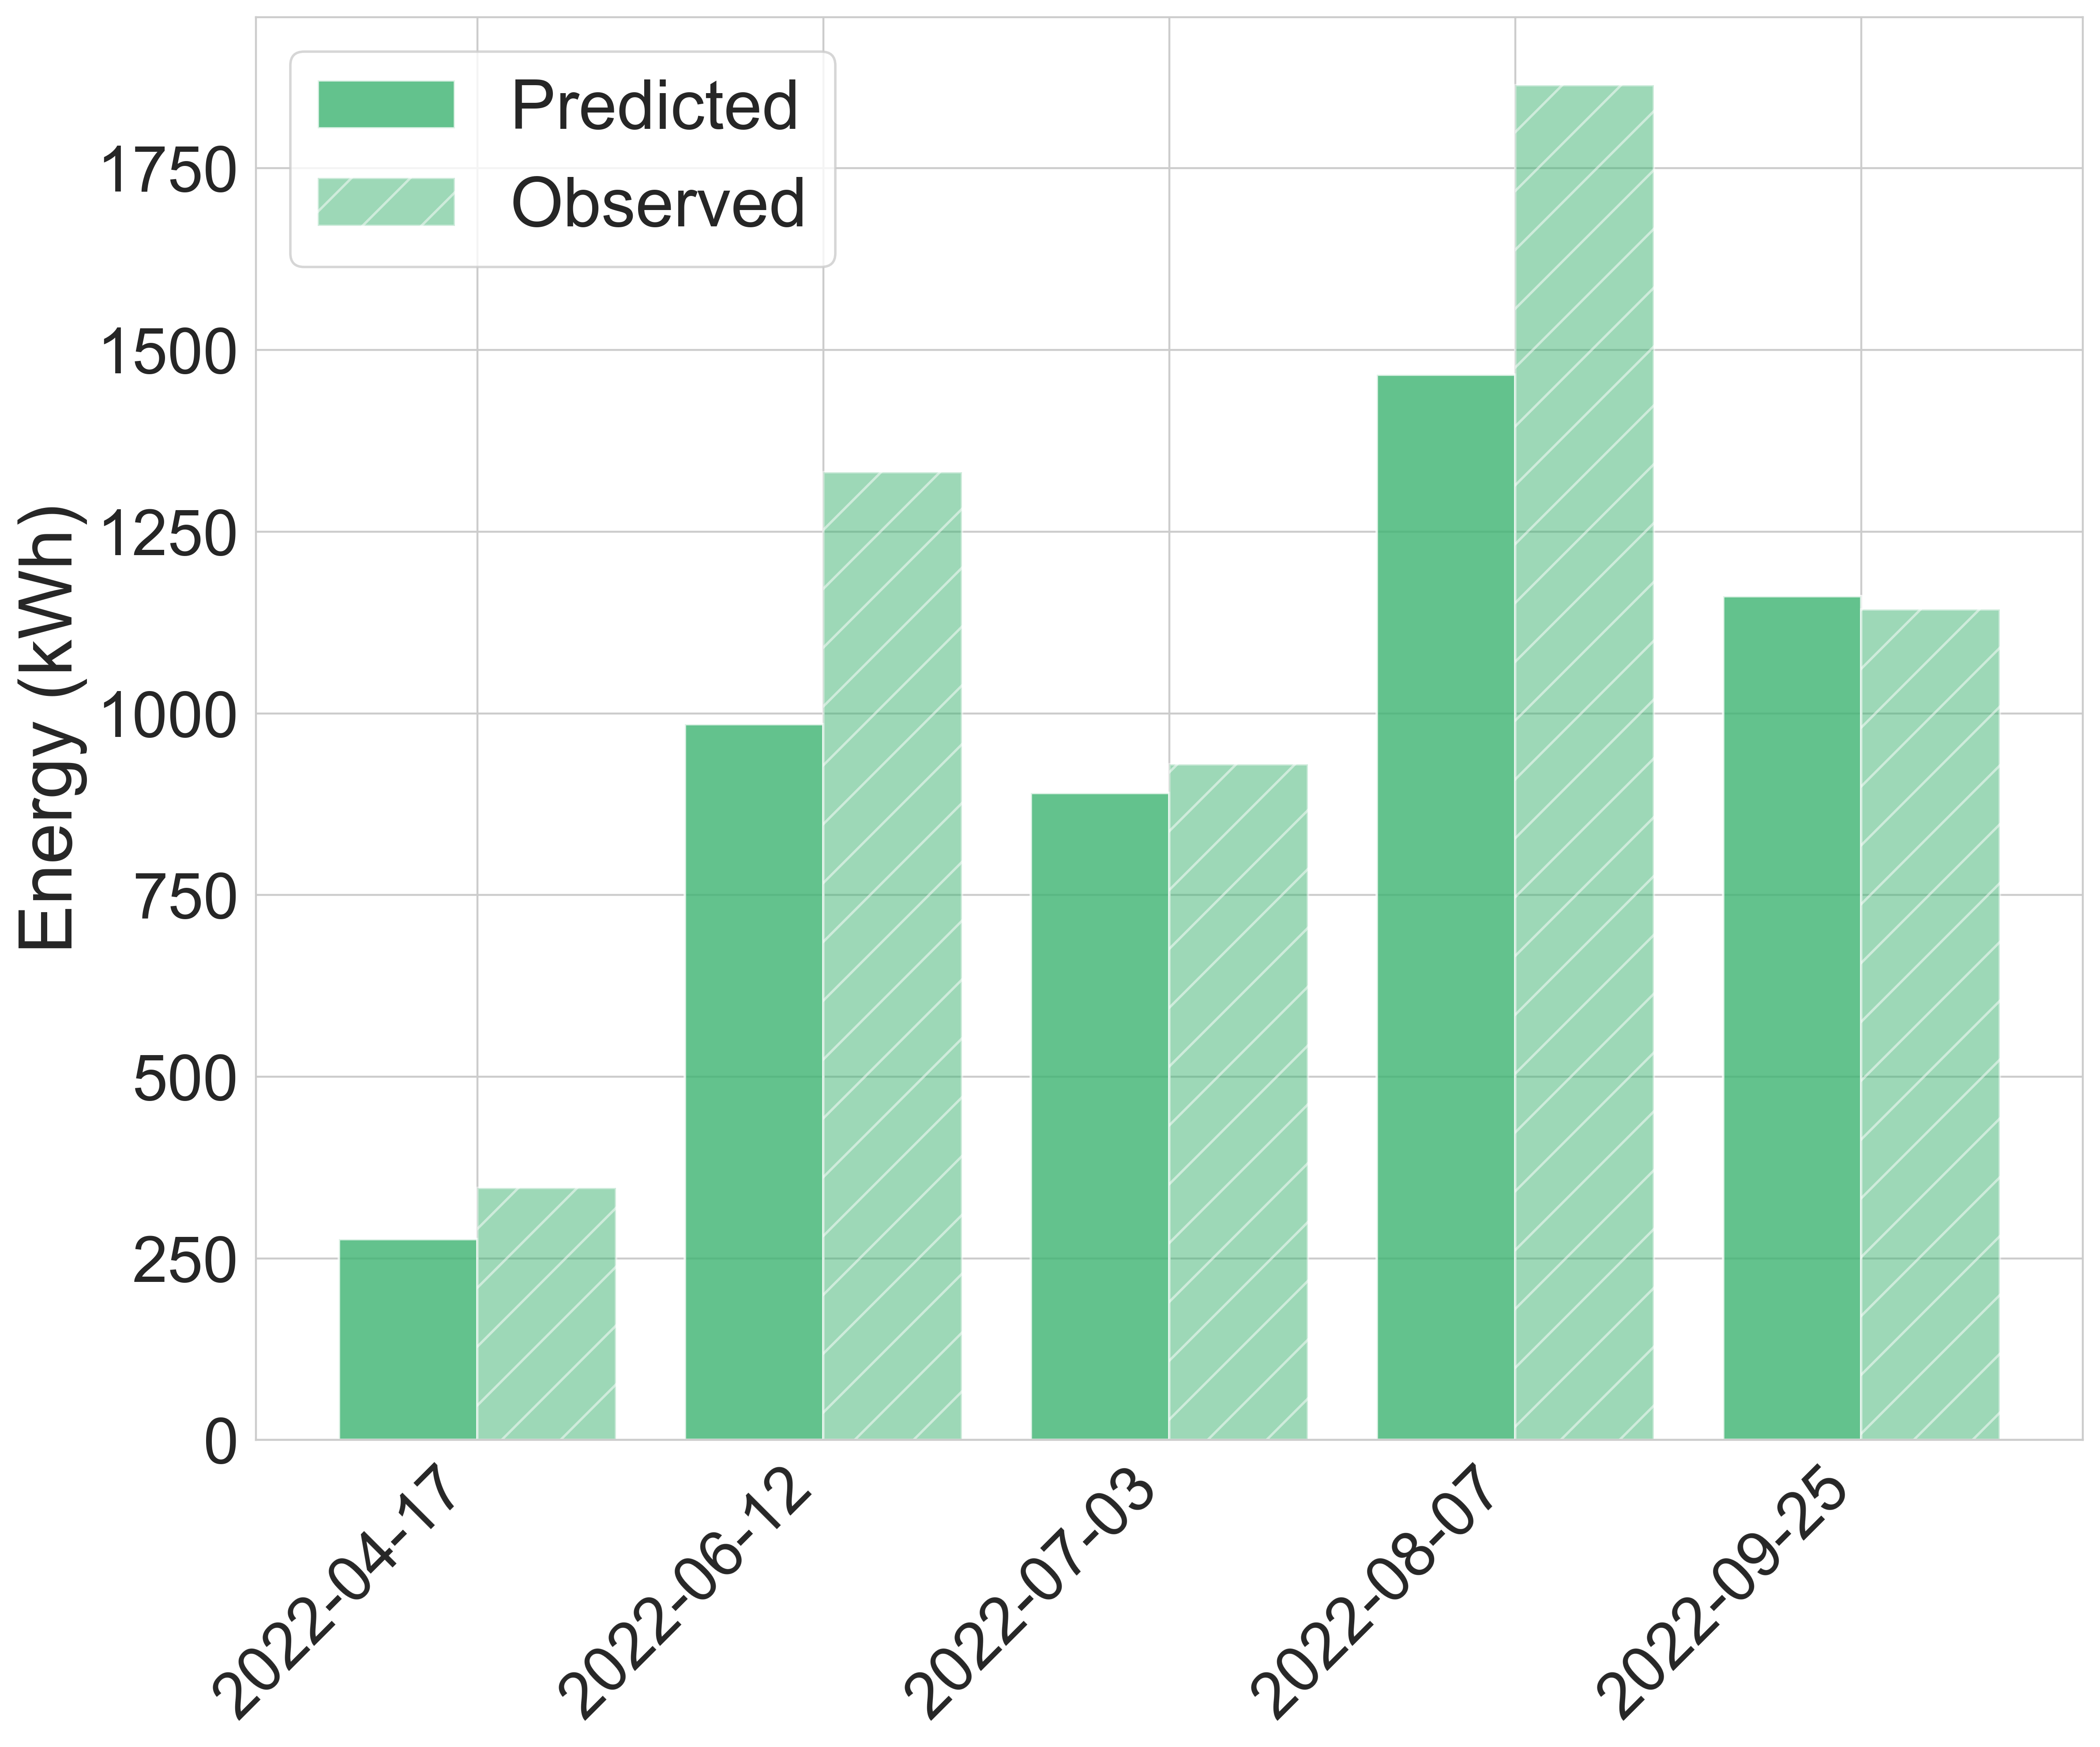

In [173]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ServiceDateTime' is a datetime object
test_merged_df['Transaction Date'] = pd.to_datetime(test_merged_df['Transaction Date'])
test_merged_df = test_merged_df.sort_values('Transaction Date')


# Set 'ServiceDateTime' as index for plotting purposes
test_merged_df.set_index('Transaction Date', inplace=True)

# Create an array with the position of each bar along the x-axis
x = np.arange(len(test_merged_df))

# Set the width of the bars
bar_width = 0.4

plt.figure(figsize=(12, 10), dpi=400)

# Plot 'Predicted' bars
plt.bar(x - bar_width/2, test_merged_df['Energy'], width=bar_width, color='mediumseagreen', alpha=0.8, label='Predicted')

# Plot 'Observed' bars
plt.bar(x + bar_width/2, test_merged_df['trip'], width=bar_width, color='mediumseagreen', alpha=0.5, hatch='/', label='Observed')

# Put the x-axis labels (ServiceDateTime) using the index values
plt.xticks(x, test_merged_df.index.strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)


plt.ylabel('Energy (kWh)', fontsize=30)
plt.legend(fontsize=28)
plt.tight_layout() 

# Save the figure with high resolution
plt.savefig(r'../../figures/weekly-BEB-Oct2021-Sep2022.png', dpi=400, bbox_inches='tight')
plt.show()


In [174]:
test_merged_df

,Energy,trip
Transaction Date,,
2022-04-17,276.747652,346.9
2022-06-12,985.399930,1332.1
2022-07-03,890.651917,929.6
2022-08-07,1466.231826,1864.7
2022-09-25,1161.163856,1142.8
